# Bagging, Boosting, and Stacking

## Contents

*   [Introduction](#intro)
*   [Theory recap](#theory)
    *   [Bagging](#bagging-t)
    *   [Boosting](#boosting-t)
    *   [Stacking](#stacking-t)
*   [Implementation](#implementation)
    *   [Bagging](#bagging-i)
    *   [Boosting](#boosting-i)
    *   [Stacking](#stacking-i)
    *   [Getting our hands dirty](#application)

## Introduction<a id="intro"></a>

You are probably aware that *bias* and *variance* are two notions we commonly consider in machine learning. If your model has too much bias, it gravitates towards one direction that will lead to classify everything as one class. If your model has too much variance, it will be unstable and make wildly different predictions for very similar instances. A simplification of these are shown below:

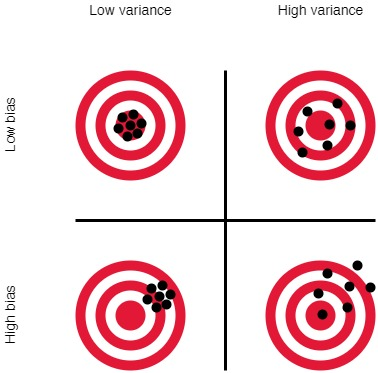

So, we want our models to have low bias and low variance. However, it is not possible to perfectly minimize bias and variance together in reality, creating this bias-variance trade-off. We practically want our models to have such a balance between bias and variance is that it obtains the most accurate results. Also, bias and variance are already introduced at every step, much before we create a model. This makes it harder for our models to learn.

The idea of [the wisdom of the crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd) suggests consulting many ordinary people in any subject can yield better results compared to a single person, even if this single person is an expert. A similar approach also works with models. Bagging, boosting, and stacking are all methods we use to create ensemble models (models made of multiple models). These models are made of weak learners (models that perform slightly better than average guess), and they improve the results.

## Theory recap<a id="theory"></a>

### Bagging<a id="bagging-t"></a>

Consider a decision tree that suffers from bias and variance. It is likely that some data points are introducing noise, but we do not know which ones. Instead of relying on a single decision tree, one thing we can do is to train multiple decision trees with random samples from the dataset. This sampling can be made with or without replacement (allowing one data point to be observed multiple times). Once we have many different decision trees trained on different samples of the same dataset, whenever we need to make a prediction, we show the same test data to all of these models and use majority voting or averaging to make a final decision. Since each model has learned slightly different data, we hope that the majority will be less affected by noise and collectively have a better judgment than a single model. This approach is called "bagging" (short for "**b**ootstrap **agg**regating") since we firstly [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) and then aggregate different models' predictions. Bagging is typically used with decision trees, and bagging of decision trees is also called a "random forest."

Bagging aims specifically to reduce variance, but it can sometimes increase bias, especially for marginalized groups since bootstrapping would lead individual models to potentially end up with even fewer observations from the rarer classes and cause the ensemble to have a bias towards the class.

### Boosting<a id="boosting-t"></a>

We learned that bagging helps us overcome noisy data. However, it is a rather naive approach since we simply hope that majority of the models in our ensemble will lead us to the correct prediction without taking some deliberate actions in learning. Boosting is typically used with decision trees as well, but with an important difference: Instead of randomly creating a forest, we grow each tree based on what we learned (which predictions were far from what was expected) from the previous one. This way, each new tree specifically tries to learn data points that the previous one failed, and potentially boost the performance. In the end, we merge these models (take their weighted average) and obtain the ideal tree we can have based on our past experience.

Boosting aims to reduce bias rather than variance. While it usually yields better results than bagging, it has some disadvantages as well. Due to its sequential nature, training can take longer. Also, since each new weak learner tries to learn from previous mistakes specifically, outliers can do more harm, so it may not perform well in high variance scenarios.

### Stacking<a id="stacking-t"></a>

Stacking is another ensemble method, but instead of using the same type of model over and over, different types of models are used. For example, random forest, SVM, and KNN models can all be trained with the same dataset. These models constitute our model stack. A k-fold approach is used with the weak learners to train and predict the class for each data point to prevent leakage. This way, after training, we check what each model predicts for each data point without seeing them in training. We store these predictions as new features. So, if our original dataset had features *Feature_1* and *Feature_2*, we now also have *RF_Predicted*, *SVM_Predicted*, and *KNN_Predicted* features, making five features in total. Then, a meta-model (usually a linear regression or a logistic regression model depending on the task) is trained using these features, making use of the model stack. Note that there are different approaches in stacking. Some approaches only use the prediction features (what stack models predict for each data point), ignoring the original features.

## Implementation<a id="implementation"></a>

While it is not that hard to implement an ensemble model (especially bagging and stacking) by ourselves, there are libraries that handle the heavy load. We will use one of these libraries, scikit-learn, to quickly make use of these ensemble approaches. Firstly, we need to install pandas, matplotlib, seaborn, scikit-learn, and shap for this lab:

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install shap

Now, we can import our sample dataset that has two features and visualize it:

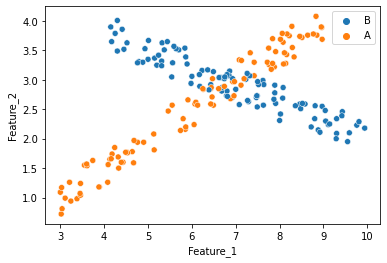

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dataset = pd.read_csv("ensemble_dataset.csv")

fig, ax = plt.subplots()
sns.scatterplot(data=dataset, x="Feature_1", y="Feature_2", hue="Class")
ax.legend()
plt.show()

We have two classes: A and B. As you can see, A and B are partially entangled, making classification hard for certain data points.

Before we move on to the ensemble models, let us observe how a decision tree performs on this dataset. We will use a 10-fold cross-validation approach to predict all data points without leakage. For this purpose, we will simply use `cross_val_score` instead of splitting the dataset and fitting the model for each fold. So, do not worry about the training part for now. The scorer uses accuracy by default, which is actually fine in this case, but we will use F1 score instead of accuracy. To do so, we will create a scorer that uses the macro-averaged F1 score. Since we will test each model the same way, we can define a custom function for this purpose. This way, we need to change the scorer code only once to apply the changes.

In [3]:
import numpy as np
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=42, max_depth=2)


def custom_score(model, dataset=dataset):
    return (
        cross_val_score(
            model,
            dataset[["Feature_1", "Feature_2"]],
            dataset["Class"],
            cv=10,
            scoring=make_scorer(f1_score, average="macro"),
        )
        .mean()
        .round(3)
    )


custom_score(decision_tree)

0.695

In order to see the difference an ensemble model can do, our decision tree is deliberately kept very weak, having a maximum depth of 2 (all leaf nodes are two split away from the root at maximum). We will now see how much we can improve upon this.

### Bagging<a id="bagging-i"></a>

We will now use a bagging approach using this base decision tree. Since we have a classification problem at our hand, we will use [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html). The page already explains the parameters it takes, but let us look at some important ones here:
*   **base_estimator:** The model that will be used to create the ensemble. We will use a decision tree here, but you could use SVC or another classifier model. By default, it is set to None, which makes the ensemble use *DecisionTreeClassifier*.
*   **n_estimators:** The number of different instances of the base estimator to be trained. So, when we make a prediction, we essentially ask the same question *n_estimators* times to different models. By default, it is 10, but this number is usually kept much higher for decision trees, mostly at least 100.
*   **max_samples:** Either the number or the ratio of sampled data points for each estimator. By default, it is 1.0, so each estimator is trained with 100 data points if the whole dataset is made of 100 data points. Be careful that having a value of 1.0 here does not make sense if you disable sampling with replacement since that would mean all estimators are trained exactly the same. See *bootstrap*.
*   **bootstrap:** A Boolean that indicates data sampling with replacement, which is True by default. Sampling with replacement means one data point can be used multiple times in the sampled dataset.
*   **warm_start:** A Boolean that indicates whether the ensemble will be trained on top of the previous training, which is False by default. If True, it means an already trained ensemble can be trained further on top of its pretraining.
*   **random_state:** An integer or None that indicates how the original dataset will be sampled for each estimator. It is None by default, so the estimators are slightly different each time we create a new ensemble. Setting an integer helps with reproducibility.
*   **verbose:** An integer that indicates the verbosity of the model, 0 by default. If greater than 0, it prints some information during training and prediction, which may come in handy for debugging or with large models. Different verbosity levels such as 1 and 2 print different amounts of information.

It has some more features that you can learn from its documentation. Some of these parameters are commonly found in scikit-learn models. 

Here, we will use the base decision tree model we used above and obtain 100 different versions of it through sampling data with replacement.

In [4]:
from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(
    base_estimator=decision_tree, n_estimators=100, random_state=42, verbose=0
)

custom_score(bagging_classifier)

0.72

We can see that it slightly improved our score.

We could also use a random forest model since our base model here is a decision tree. The difference between implementing a bagging ensemble and a random forest is that the weak learners in a random forest randomly consider a subset of features to split the data while a bagging ensemble considers all features. Here is the random forest version:

In [5]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=2, random_state=42, max_features=None)

custom_score(random_forest)

0.72

We obtained the same result. Note that we need to use `max_features=None` or `max_features=1.0` to force the model to consider all features during the split. By default, it randomly considers $\sqrt{n\_features}$ features (in our case, $\sqrt{2}$ is rounded to 1). You can learn more about RandomForestClassifier from [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

With a single decision tree, explaining the decision process and feature importances are trivial. While bagging improves our results, it is less explainable than a single decision tree. We could pick some of the trees from our ensemble and explain them, but they are unlikely to represent the whole ensemble. For this reason, we can use Shapley values to explain how much each feature contributes to the prediction. We will fit our model instead of scoring it and then use SHAP (SHapley Additive exPlanations) package to do this:

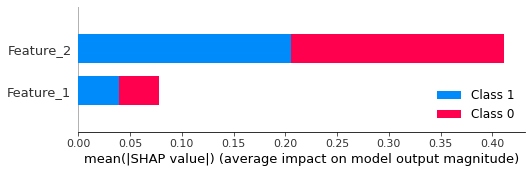

In [6]:
import shap

random_forest.fit(dataset[["Feature_1", "Feature_2"]], dataset["Class"])

explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(dataset[["Feature_1", "Feature_2"]])

shap.summary_plot(shap_values, dataset[["Feature_1", "Feature_2"]])

We can see each feature's overall and class-specific importance for prediction. From the previous plot, we can see the class is solely A if Feature_2 < 2. Therefore, as expected, Feature_2 helps more than Feature_1, having a larger impact.

### Boosting<a id="boosting-i"></a>

Compared to bagging, boosting is a more sophisticated approach, and it has multiple different implementations. The original one is called AdaBoost (short for **Ada**ptive **Boost**ing), which works the way the recap briefly explains. [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) is fairly easy to use as it does not have many parameters anyway. Most of its important parameters are explained with BaggingClassifier. One difference is having `learning_rate` parameter that defines the weight, 1.0 by default, that determines how much an individual estimator contributes in overall.

In [7]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(
    base_estimator=decision_tree, n_estimators=100, random_state=42
)

custom_score(adaboost_classifier)

0.92

Remember that we are using our weak decision tree model (*decision_tree*) as the base estimator. Considering the score of the base estimator by itself is 0.695, we made a significant improvement. There are some other boosting implementations, such as Gradient Boosting and Extreme Gradient Boosting. If you are interested in tree boosting, you can check [XGBoost](https://xgboost.readthedocs.io/en/stable/), a popular Python package specifically written for this purpose.

We need to keep in mind that there is an interplay between the number of estimators and the learning rate. Learning rate practically defines how much our model should learn from each observation, while the number of estimators practically defines how many iterations will learning take (in this context). A model with a lower number of estimators but a higher learning rate can learn more "efficiently" and yield better results, but it is risky because it is like flipping a coin and learning so much from that flip that all the following flips will result in the same outcome. You should not make drastic generalizations from just one coin flip and expect all flips to result in heads only because your last flip resulted in heads. Meanwhile, a very low learning rate would cause the model to take longer iterations (number of estimators in this context) to learn the concept.

Since we do not know the ideal values for these parameters, we need to do some experimentation to find the ideal values for our specific case, which is known as hyperparameter optimization. A not-so-efficient yet very simple hyperparameter optimization method is grid search. In grid search, we basically define specific values each parameter can take and look at the outcomes for every possible combination of these values. For two parameters, we can simply think like a nested loop:

In [8]:
n_estimators = range(20, 201, 20)  # Possible values for n_estimator
learning_rates = [0.5, 1, 1.5, 2]  # Possible values for learning_rate

for n_estimator in n_estimators:
    for learning_rate in learning_rates:
        adaboost_classifier = AdaBoostClassifier(
            base_estimator=decision_tree,
            n_estimators=n_estimator,
            learning_rate=learning_rate,
            random_state=42,
        )
        print(
            "Number of estimators: {} \tLearning rate: {} \tScore: {}".format(
                n_estimator, learning_rate, custom_score(adaboost_classifier)
            )
        )

Number of estimators: 20 	Learning rate: 0.5 	Score: 0.915
Number of estimators: 20 	Learning rate: 1 	Score: 0.914
Number of estimators: 20 	Learning rate: 1.5 	Score: 0.925
Number of estimators: 20 	Learning rate: 2 	Score: 0.889
Number of estimators: 40 	Learning rate: 0.5 	Score: 0.915
Number of estimators: 40 	Learning rate: 1 	Score: 0.905
Number of estimators: 40 	Learning rate: 1.5 	Score: 0.935
Number of estimators: 40 	Learning rate: 2 	Score: 0.9
Number of estimators: 60 	Learning rate: 0.5 	Score: 0.92
Number of estimators: 60 	Learning rate: 1 	Score: 0.91
Number of estimators: 60 	Learning rate: 1.5 	Score: 0.92
Number of estimators: 60 	Learning rate: 2 	Score: 0.9
Number of estimators: 80 	Learning rate: 0.5 	Score: 0.905
Number of estimators: 80 	Learning rate: 1 	Score: 0.91
Number of estimators: 80 	Learning rate: 1.5 	Score: 0.92
Number of estimators: 80 	Learning rate: 2 	Score: 0.905
Number of estimators: 100 	Learning rate: 0.5 	Score: 0.91
Number of estimators: 

We see that `n_estimator=40` and `learning_rate=1.5` together yield a better score (0.935) compared to having a model that has `n_estimator=100` and `learning_rate=1`. We could also use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) that handles these for us. Using [Optuna](https://github.com/optuna/optuna) is another option.

We have been dealing with a classification problem, so our models are classification models. In case your task is regression, you can look at [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) that will use [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) as the base estimator.

### Stacking<a id="stacking-i"></a>

For stacking, we will use [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html). Let us look at some important parameters:
*   **estimators:** A list of tuples that have a string (for identification purpose) and an estimator, estimator name, or pipeline (a bundle of model and some processing methods) along w. So, we can use `DecisionTreeClassifier` (uses the default values), `DecisionTreeClassifier(random_state=42, max_depth=2)`, or `decision_tree` (given that *decision_tree* is previously defined as an estimator). This will become clearer when we get to the code.
*   **final_estimator:** The meta model that will learn the predictions of the stacked models. It is set to [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) by default.
*   **cv:** An integer that indicates the number of folds, a cross-validation generator, or an iterable that yields the splits themselves. Cross-validation is necessary in stacking because the final (meta) estimator needs all data points to be predicted by all weak estimators, but we cannot simply train a weak estimator with the whole dataset at once. To prevent leakage, stacking uses cross-validation.
*   **stack_method:** This parameter specifies which method to call of an estimator to make a prediction, "auto" by default. If this is set to "auto," it will try to invoke `predict_proba`, `decision_function`, and `predict` methods for the stack models in this order. Otherwise, you need to specify  the method name (one of these three methods).
*   **passthrough:** A Boolean that indicates whether the original features are passed through the stack for the metal model, False by default. If True, the meta model uses both stacked model predictions and the original data.

What is nice about this approach is that we can combine it with the previous approaches. While we could include our weak decision tree in the stack, we have already obtained much better models in the process. So, we can add a boosting ensemble with the optimized parameters for efficiency. To make use of stacking, we will also use [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (in a pipeline with a scaler) and [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# This has the best parameter values based on the grid search we have just made.
adaboost_classifier = AdaBoostClassifier(
    base_estimator=decision_tree, n_estimators=40, learning_rate=1.5, random_state=42
)

stack = [
    ("adaboost", adaboost_classifier),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=42))),
    ("knn", KNeighborsClassifier(n_neighbors=5)),
]

stacking_classifier = StackingClassifier(estimators=stack, cv=10, passthrough=True)

custom_score(stacking_classifier)

0.945

All models in our stack can score better than 0.9 by themselves, but combining them altogether yields an even better score.

Notice that we did not specify anything for `stack_method`, so it is set to "auto." Therefore, when we want to make a prediction, our ensemble will first try to predict class membership probabilities using the models in its stack instead of directly predicting a class. Predicting probabilities for one observation yields a 1x$n$ dimensional vector for an $n$-class prediction. Since we have two classes here ("A" and "B"), a model with `predict_proba` method in the stack would return `[P(A), P(B)]` instead of returning "A" or "B." This gives us (and the meta model) more information, because two different observations with class probabilities `[0.6, 0.4]` and `[0.9, 0.1]` would both be labeled as "A," but the first observation may be more likely to be misclassified. Therefore, it is generally a good idea to keep this parameter set to "auto."

By looking at the documentation, we see that [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) all have `predict_proba` method. Considering we also have `passthrough=True` parameter, what is your guess about the number of features we have for our meta model?

To see this, let us actually train the stacking ensemble instead of using a scorer and see the format data is transformed into for final prediction. Firstly, we will train the model using `fit`, giving the features and the target class columns separately):

In [10]:
stacking_classifier.fit(dataset[["Feature_1", "Feature_2"]], dataset["Class"])

StackingClassifier(cv=10,
                   estimators=[('adaboost',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                                         random_state=42),
                                                   learning_rate=1.5,
                                                   n_estimators=40,
                                                   random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(random_state=42))])),
                               ('knn', KNeighborsClassifier())],
                   passthrough=True)

Now that it is trained, let us transform the dataset itself and see the features that are used to train the meta model:

In [11]:
stacking_classifier.transform(dataset[["Feature_1", "Feature_2"]])[
    :5
]  # Retrieving the first five rows

array([[ 0.99700131,  1.16873895,  1.        ,  5.56      ,  3.29      ],
       [ 0.25519177,  0.22736189,  0.4       ,  7.08      ,  3.34      ],
       [ 0.9715912 ,  1.00033278,  1.        ,  7.29      ,  2.63      ],
       [ 0.99880768,  1.2615336 ,  1.        ,  5.01      ,  3.67      ],
       [ 0.04891248, -1.12440678,  0.        ,  3.21      ,  1.26      ]])

This might surprise you, because we have five features. Considering we actually retrieve the class probabilities from each stack estimator, we would expect to see **2** (the original features) + **2** (class probabilities from AdaBoostClassifier) + **2** (class probabilities from SVC) + **2** (class probabilities from KNeighborsClassifier) = **8 features**.

The reason we do not see that many features is using both classes' probabilities does not help us due to collinearity (one probability linearly decreases while the other linearly increases). If the probability of one data point being an A is 0.9, we can immediately tell that its probability being a B is 1 - 0.9 = 0.1. Therefore, in binary classification problems, our stacking ensemble drops one of the probabilities automatically, yielding **2** (the original features) + **1** (one class's probability from AdaBoostClassifier) + **1** (one class's probability from SVC) + **1** (one class's probability from KNeighborsClassifier) = **5 features**.

Still, using "auto" (or "predict_proba" if we know all stack estimators have the method) instead of "predict" yields better results due to working with non-rounded predictions. Our stacking ensemble's score was 0.945. Let us see its score when we forcefully use the `predict` method of our stack models:

In [12]:
stacking_classifier = StackingClassifier(
    estimators=stack, cv=10, stack_method="predict", passthrough=True
)

custom_score(stacking_classifier)

0.94

There is a slight decrease.

### Getting our hands dirty<a id="application"></a>

It was mentioned how using `cross_val_score` handles cross-validation, training, and prediction in the background for us. It is a neat function to assess a model. However, we are mostly interested in making predictions and using them, so it is not as useful for practical applications. For this reason, we will now implement an ensemble model by explicitly creating some cross-validation folds and training our model.

We will use bagging here, but you can also directly apply this to the other approaches. Here is our original weak learner:

In [13]:
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=2)

Since we want to train our ensemble with all data points and score it for all data points without data leakage, we will manually define cross-validation folds and keep the data points for which we will test our ensemble separate. We will create our ensemble model for each fold and sample the training data for each tree with slight randomization. Once we train each estimator in a fold, we will make predictions for all data points from our test split and use a majority vote to determine the final prediction. Then, we calculate the F1 score from the test split and average the fold scores to obtain the final F1 score:

In [14]:
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

n_estimators = 100

cross_val_splitter = StratifiedKFold(
    n_splits=10
)  # Using the stratified version just to make sure splits are homogenized

f1_scores = []

for fold_index, (train_index, test_index) in enumerate(
    cross_val_splitter.split(dataset[["Feature_1", "Feature_2"]], dataset["Class"])
):
    print("Fold", fold_index + 1)
    print("Test indices:", test_index)

    bagging_ensemble = [decision_tree] * n_estimators

    # Each fold has a different testing set
    test_x = dataset.loc[test_index, ["Feature_1", "Feature_2"]]
    test_y = dataset.loc[test_index, "Class"]

    ensemble_predictions = []

    for estimator_id, estimator in enumerate(bagging_ensemble):
        sampled_train_index = resample(
            train_index, replace=True, random_state=estimator_id
        )  # Sampling indices that will be used for training with replacement

        train_x = dataset.loc[sampled_train_index, ["Feature_1", "Feature_2"]]
        train_y = dataset.loc[sampled_train_index, "Class"]

        # We train each estimator with a sample of the training split
        bagging_ensemble[estimator_id].fit(train_x, train_y)

    for test_id in test_index:
        estimator_predictions = []
        for estimator in bagging_ensemble:
            estimator_prediction = estimator.predict([test_x.loc[test_id]])
            estimator_predictions.extend(estimator_prediction)

        majority_vote = Counter(estimator_predictions).most_common(1)[0][0]
        ensemble_predictions.append(majority_vote)

    fold_f1_score = f1_score(test_y, ensemble_predictions, average="macro")
    f1_scores.append(fold_f1_score)

avg_f1_score = np.mean(f1_scores).round(3)

print("Average F1 score:", avg_f1_score)

Fold 1
Test indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20]
Fold 2
Test indices: [19 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40]
Fold 3
Test indices: [37 41 42 43 44 45 46 47 48 49 50 51 52 53 55 56 59 61 62 63]
Fold 4
Test indices: [54 57 58 60 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 80]
Fold 5
Test indices: [ 79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
 101 104]
Fold 6
Test indices: [ 98  99 100 102 103 105 106 107 108 109 110 111 112 115 118 119 123 125
 126 128]
Fold 7
Test indices: [113 114 116 117 120 121 122 124 127 129 130 131 132 135 136 137 138 140
 141 146]
Fold 8
Test indices: [133 134 139 142 143 144 145 147 148 149 150 151 152 153 154 156 157 159
 160 161]
Fold 9
Test indices: [155 158 162 163 164 165 166 167 168 169 170 171 172 173 175 178 179 181
 183 185]
Fold 10
Test indices: [174 176 177 180 182 184 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Average F1 score: 0.706


We see each row in our dataset is given to one of 10 folds for prediction.

We get something close to BaggingClassifier's score. Note that this implementation is not for making predictions, it is simply used to determine the ensemble's with all data points at hand without leakage, and it is an approximation. If we were to make actual predictions, we would firstly split our dataset to train and test splits, simply train our ensemble with the entire training split and test it with the whole testing split. For model selection and hyperparameter optimization, we would also split the training set into training and validation sets.